In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import plotly.express as px
from scipy.optimize import minimize
import pandas as pd
import numpy as np
from datetime import datetime
import time
import datetime
import math

In [2]:
### MCMC

def MCMC(r0,params,N=1000,T=12*30,dT=1/12,model='Vasicek',seed=500,rvs=None):
  if rvs is None:
    np.random.seed(seed)
    rvs = np.random.normal(0, 1, (N, T))
  r = np.zeros((N, T))
  r[:, 0] = r0
  a, b, sig = params
  if model == 'CIR':
    for i in range(1, T):
      r[:, i] = r[:, i-1] + a*(b-r[:, i-1])*dT + np.sqrt(r[:, i-1])*rvs[:, i]*math.sqrt(dT)*sig
      r[:, i][r[:, i] < 0] = 0
  if model == 'Vasicek':
    for i in range(1, T):
      r[:, i] = r[:, i-1] + a*(b-r[:, i-1])*dT + r[:, i-1]*rvs[:, i]*math.sqrt(dT)*sig
      r[:, i][r[:, i] < 0] = 0

  return r


In [3]:
params = [0.06, 0.06, 0.022]
r0 = 0.043
r = MCMC(r0, params)

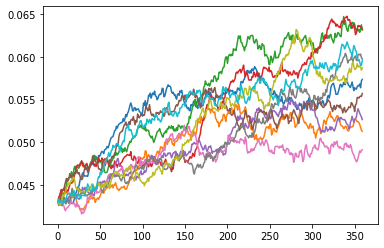

In [ ]:
plt.figure()
for i in range(10):
  plt.plot(r[i])
plt.show()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This code generates the a dataframe of simulations of discount factors with datetime index.

In [4]:
j=r.transpose()
g=np.ones((j.shape))          

for i in range(j.shape[1]):
  for k in range(j.shape[0]):
    j[k,i]=(1/(1+j[k,i]))**(1/12)

for i in range(0,g.shape[1]):
  for k in range(0,g.shape[0]):
    if k==0:
      g[k][i]=j[k][i]
    else:
      g[k][i]=j[k][i]*g[k-1][i]

df = pd.DataFrame (g)
df2=pd.date_range(start='11/01/2022', periods=360, freq='M')
listed=list(df2)
for i in range(len(listed)):
  listed[i]=listed[i].replace(day=1)
df['date']=listed
df=df.set_index('date')

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
date,,,,,,,,,,,,,,,,,,,,,
2022-11-01,0.996498,0.996498,0.996498,0.996498,0.996498,0.996498,0.996498,0.996498,0.996498,0.996498,...,0.996498,0.996498,0.996498,0.996498,0.996498,0.996498,0.996498,0.996498,0.996498,0.996498
2022-12-01,0.992997,0.993000,0.993018,0.992962,0.993007,0.993025,0.993036,0.993041,0.993028,0.992982,...,0.993032,0.992986,0.992976,0.993007,0.993013,0.993024,0.992995,0.992978,0.992984,0.992988
2023-01-01,0.989488,0.989475,0.989552,0.989425,0.989537,0.989542,0.989572,0.989569,0.989555,0.989512,...,0.989589,0.989466,0.989459,0.989518,0.989510,0.989536,0.989478,0.989424,0.989483,0.989465
2023-02-01,0.985942,0.985940,0.986052,0.985875,0.986097,0.986059,0.986129,0.986108,0.986112,0.986049,...,0.986133,0.985969,0.985953,0.986021,0.986020,0.986013,0.985950,0.985866,0.985992,0.985998
2023-03-01,0.982408,0.982422,0.982577,0.982309,0.982651,0.982544,0.982697,0.982685,0.982657,0.982583,...,0.982679,0.982471,0.982435,0.982529,0.982559,0.982473,0.982422,0.982355,0.982513,0.982574


In [80]:

def pricing(bond):
  simulations=[]
  for i in range(0,100):
    sum=0
    for j in range(1,len(bond)):
      if np.isnan(bond[i][j])==False:
        sum=sum+(bond[i][j])*(bond.iloc[j,2])
    final= 100*(sum/(bond.iloc[(len(bond)-1),2]-bond.iloc[1,2]))
    simulations.append(final) 
  return simulations

In [ ]:
def bond_pricing(lists,interest): # Taking the list of isins as the argument
  d={}
  value={}
  for name in lists:
   d[name] = pd.read_excel("/content/drive/Shareddrives/FIM 500 project group/Data/FinalBonds/"+name+".xlsx",nrows=2) # The dataframes are elements of the dictionary d
   d[name].set_index('Date',inplace=True)
   d[name]=d[name].transpose()
   d[name]=d[name].dropna(axis=1, how='all')
   d[name].index = pd.to_datetime(d[name].index)
   d[name].reset_index(inplace=True)
   d[name] = d[name].rename(columns = {'index':'date'})
   d[name]['modified_date'] = d[name]['date'] - pd.offsets.MonthBegin(1, normalize=True)
   d[name].set_index('modified_date', inplace=True)
   d[name]=d[name].join(interest)
   d[name].reset_index(inplace=True)
   d[name] = d[name].rename(columns = {'index':'modified_date'})
   value[name]=pricing(d[name])
  return d,value
# pass the isin in the list  
list_isin=['US808513BP97','US892331AD13','US00254EMY58','US135087N757','US911312BJ41','US22550L2J94','US25155MKW00','US38141GZP26','US404280AU33'	,'US606822BS23',' US06051GFS30']
bond_data,values=bond_pricing(list_isin,df)

# The output is the value dictionary which contains the isins and the prices

In [ ]:
print(bond_data)

{'US808513BP97': [103.07448720830139, 103.43906508069493, 103.72347489522787, 103.69278919682976, 103.0623991091215, 103.17419660974679, 102.97938405643625, 103.11537145052083, 103.13711104672126, 102.9930745627136, 103.22219906513925, 103.11793899344667, 103.53325390200246, 103.41706887720004, 103.39426918575589, 102.99805483161062, 103.14731651156026, 103.47375837400669, 103.71596568438677, 103.32299828360215, 103.72080208854082, 103.56527310865849, 103.70139039304563, 102.92673062006573, 103.44141597011027, 102.92065669860446, 102.59075726319541, 103.3821984075892, 103.06766822937581, 103.4100175597995, 103.32447565336791, 103.39404212908723, 103.21846185617261, 103.18244129048114, 103.38142398972923, 102.78793308095055, 103.49754117771262, 102.75500517598097, 103.57306775752966, 103.00782115300218, 103.01111573439321, 103.60636360538606, 103.39493764944301, 103.2983543577668, 103.6490562646665, 103.06140603066349, 103.45692185320404, 103.98822276815038, 103.68028854946493, 103.2574

In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from scipy.optimize import minimize
from scipy.optimize import brute
from sklearn.metrics import accuracy_score

#from model import CalibratableModelFactory
#from plotting import (plot_calibration_curve,plot_calibration_details_for_models,plot_fitted_calibrator, plot_sample)

##Dividing Data into Training and Test Sets

In [46]:
price_curr=pd.read_excel("/content/drive/Shareddrives/FIM 500 project group/Data/Pure_Bonds.xlsx")
X_train,X_test,y_train,y_test=train_test_split(price_curr["ISIN"],price_curr["Prices"],test_size=0.2)
X_1=X_train.to_list()
X_2=X_test.to_list()

##Training Data Calibration VASICEK MODEL


In [53]:
#using 480 bonds 80% of data
lists=X_1#['US808513BN40',	'US00254EMY58',	'US135087N757',	'US22550L2J94',	'US25155MKW00',	'US38141GZP26',	'US404280AU33',	'US606822BS23',	' US06051GFS30',	'US857477AW33',	'US00254EMZ24',	'US02209SAS23',	'US06739FHV67',	'US89114QCA40',	'US025816AZ26',	'US46625HRS12',	'US539439AS89',	'US298785HX70',	'US88579YAV39',	'US001055AM48',	'US1730T32J13',	'US931142CH46',	'US617482V925',	'US606822AN45',	'US251525AP63',	'US001055AM48',	'US1730T32J13']
def calib(params,lists,sig=0,r0=.043,N=100,T=12*30,dT=1/12,model='Vasicek',seed=500,rvs=None ):
  #generating interest rate sims
  if rvs is None:
    np.random.seed(seed)
    rvs = np.random.normal(0, 1, (N, T))
  r = np.zeros((N, T))
  r[:, 0] = r0
  a,b = params
  if model == 'CIR':
    for i in range(1, T):
      # counter = 0
      # print("checker", r[:, i-1])
      # print(r[:, i-1].shape)
      # if(np.isnan(r[:, i-1].any())):
      #   print("checker", r[:10, i-1])
      #   counter += 1
      # print(counter)
      r[:, i] = r[:, i-1] + a*(b-r[:, i-1])*dT + np.sqrt(r[:, i-1])*rvs[:, i]*math.sqrt(dT)*sig
      r[:, i][r[:, i] < 0] = 0
  if model == 'Vasicek':
    for i in range(1, T):
      r[:, i] = r[:, i-1] + a*(b-r[:, i-1])*dT + r[:, i-1]*rvs[:, i]*math.sqrt(dT)*sig
      r[:, i][r[:, i] < 0] = 0

  #creating discount rates from rates
  j=r.transpose()
  g=np.ones((j.shape))          

  for i in range(j.shape[1]):
    for k in range(j.shape[0]):
      j[k,i]=(1/(1+j[k,i]))**(1/12)

  for i in range(0,g.shape[1]):
    for k in range(0,g.shape[0]):
      if k==0:
        g[k][i]=j[k][i]
      else:
        g[k][i]=j[k][i]*g[k-1][i]

  df = pd.DataFrame (g)
  df2=pd.date_range(start='11/01/2022', periods= T, freq='M')
  listed=list(df2)
  for i in range(len(listed)):
    listed[i]=listed[i].replace(day=1)
  df['date']=listed
  df=df.set_index('date')

  #pricing function definition
  d={}
  value={}
  for name in lists:
   d[name] = pd.read_csv("/content/drive/Shareddrives/FIM 500 project group/Data/BBG Bond Data/"+name+".csv",nrows=2) # The dataframes are elements of the dictionary d
   d[name].set_index('Date',inplace=True)
   d[name]=d[name].transpose()
   d[name]=d[name].dropna(axis=1, how='all')
   d[name].index = pd.to_datetime(d[name].index)
   d[name].reset_index(inplace=True)
   d[name] = d[name].rename(columns = {'index':'date'})
   d[name]['modified_date'] = d[name]['date'] - pd.offsets.MonthBegin(1, normalize=True)
   d[name].set_index('modified_date', inplace=True)
   d[name]=d[name].join(df)
   d[name].reset_index(inplace=True)
   d[name] = d[name].rename(columns = {'index':'modified_date'})
   value[name]=pricing(d[name])
  avg_value={}
  for k, v in value.items():
    avg_value[k]=sum(v)/ int(len(v))
  #calculating MSE between current price and predicted Price
  price_pred=pd.DataFrame(avg_value.items() , columns=['ISIN', 'Price_Predicted'])
  price_curr=pd.read_excel("/content/drive/Shareddrives/FIM 500 project group/Data/Pure_Bonds.xlsx")
  MSE_df=pd.merge(price_pred,price_curr,on='ISIN')
  MSE_df=MSE_df.rename(columns={'Prices':'Price_Current'})
  MSE_df["Price_Current"]=pd.to_numeric(MSE_df["Price_Current"])
  MSE_df["Price_Predicted"]=pd.to_numeric(MSE_df['Price_Predicted'])
  MSE_df['Error']=MSE_df['Price_Predicted']-MSE_df['Price_Current']
  SSS=np.square(MSE_df['Error']).mean()
  #MSE_df['curr_price']=pd.merge(MSE_df,price_curr,how='left') 
  #Variance=(MSE_df['MSE']**2).mean()-(MSE_df['MSE'].mean())**2
  #minimising variance based on parameters
  return SSS, MSE_df

   

In [54]:
t=calib([0,0.02],lists)

In [55]:
t[0]

5.569748733153708

In [70]:
vasicek_fixed=t[1]
vasicek_fixed

,ISIN,Price_Predicted,Price_Current,Error
0,US3130A8HK24,96.592092,95.556999,1.035093
1,US02665WCZ23,97.843224,95.981003,1.862221
2,US878055AE23,101.520541,98.000000,3.520541
3,US91324PEN87,99.975257,101.088997,-1.113740
4,US89236TJT34,94.402750,93.481003,0.921747
...,...,...,...,...
675,US14020ABX19,100.385249,97.349998,3.035250
676,US74368CBL72,97.908587,94.554001,3.354586
677,US832432AJ78,92.175907,90.886597,1.289311
678,US89236TGL35,95.720511,94.883003,0.837508


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd34c6b63a0>]],
      dtype=object)

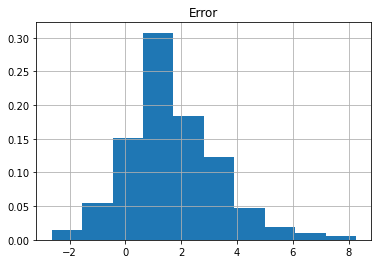

In [100]:
vasicek_fixed.hist("Error", density=True)

#Optimization with SLSQP Method

In [ ]:
bnd=[(0,1000),(0,0.2)]
params=[0.2,0.02]
s=minimize(calib,params,method='SLSQP',bounds=bnd,args=(lists,))
if s.success:
    fitted_params_SLSQP = s.x
    print(fitted_params_SLSQP)



[0.97793747 0.05670868]


#MSE with calibrated parameters

In [51]:
l=calib([0.97793747,.05670868],lists)
l[0]

2.756724233909122

In [76]:
Vasicek_train_calibrated=l[1]
Vasicek_train_calibrated[Vasicek_train_calibrated["Error"]>5]

,ISIN,Price_Predicted,Price_Current,Error
76,US172967AL52,109.963565,104.526001,5.437564
299,US620076AH21,108.908437,102.714996,6.193441
674,US53079QAB32,111.722112,105.898003,5.824109


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd34522bc70>]],
      dtype=object)

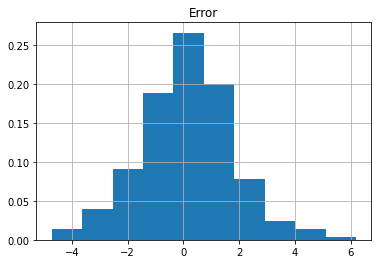

In [99]:
Vasicek_train_calibrated.hist("Error", density=True)

In [ ]:
params = [0.97793,.056708,.0221]
r0 = 0.043
d = MCMC(r0, params)


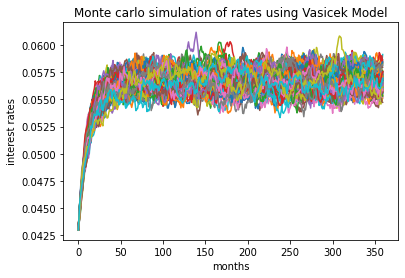

In [ ]:
plt.figure()
plt.xlabel("months")
plt.ylabel("interest rates")
plt.title("Monte carlo simulation of rates using Vasicek Model")
for i in range(100):
  plt.plot(d[i])
plt.show()

#Testing Calibrated Parameters: Vasicek Model

In [95]:

lists= X_2
def calib1(params,lists,sig=0.0221,r0=.043,N=1000,T=12*30,dT=1/12,model='Vasicek',seed=500,rvs=None ):
  #generating interest rate sims
  if rvs is None:
    np.random.seed(seed)
    rvs = np.random.normal(0, 1, (N, T))
  r = np.zeros((N, T))
  r[:, 0] = r0
  a,b = params
  if model == 'CIR':
    for i in range(1, T):
      # counter = 0
      # print("checker", r[:, i-1])
      # print(r[:, i-1].shape)
      # if(np.isnan(r[:, i-1].any())):
      #   print("checker", r[:10, i-1])
      #   counter += 1
      # print(counter)
      r[:, i] = r[:, i-1] + a*(b-r[:, i-1])*dT + np.sqrt(r[:, i-1])*rvs[:, i]*math.sqrt(dT)*sig
      r[:, i][r[:, i] < 0] = 0
  if model == 'Vasicek':
    for i in range(1, T):
      r[:, i] = r[:, i-1] + a*(b-r[:, i-1])*dT + r[:, i-1]*rvs[:, i]*math.sqrt(dT)*sig
      r[:, i][r[:, i] < 0] = 0

  #creating discount rates from rates
  j=r.transpose()
  g=np.ones((j.shape))          

  for i in range(j.shape[1]):
    for k in range(j.shape[0]):
      j[k,i]=(1/(1+j[k,i]))**(1/12)

  for i in range(0,g.shape[1]):
    for k in range(0,g.shape[0]):
      if k==0:
        g[k][i]=j[k][i]
      else:
        g[k][i]=j[k][i]*g[k-1][i]

  df = pd.DataFrame (g)
  df2=pd.date_range(start='11/01/2022', periods= T, freq='M')
  listed=list(df2)
  for i in range(len(listed)):
    listed[i]=listed[i].replace(day=1)
  df['date']=listed
  df=df.set_index('date')

  #pricing function definition
  d={}
  value={}
  for name in lists:
   d[name] = pd.read_csv("/content/drive/Shareddrives/FIM 500 project group/Data/BBG Bond Data/"+name+".csv",nrows=2) # The dataframes are elements of the dictionary d
   d[name].set_index('Date',inplace=True)
   d[name]=d[name].transpose()
   d[name]=d[name].dropna(axis=1, how='all')
   d[name].index = pd.to_datetime(d[name].index)
   d[name].reset_index(inplace=True)
   d[name] = d[name].rename(columns = {'index':'date'})
   d[name]['modified_date'] = d[name]['date'] - pd.offsets.MonthBegin(1, normalize=True)
   d[name].set_index('modified_date', inplace=True)
   d[name]=d[name].join(df)
   d[name].reset_index(inplace=True)
   d[name] = d[name].rename(columns = {'index':'modified_date'})
   value[name]=pricing(d[name])
  avg_value={}
  for k, v in value.items():
    avg_value[k]=sum(v)/ int(len(v))
  #calculating MSE between current price and predicted Price
  price_pred=pd.DataFrame(avg_value.items() , columns=['ISIN', 'Price_Predicted'])
  price_curr=pd.read_excel("/content/drive/Shareddrives/FIM 500 project group/Data/Pure_Bonds.xlsx")
  MSE_df=pd.merge(price_pred,price_curr,on='ISIN')
  MSE_df=MSE_df.rename(columns={'Prices':'Price_Current'})
  MSE_df["Price_Current"]=pd.to_numeric(MSE_df["Price_Current"])
  MSE_df["Price_Predicted"]=pd.to_numeric(MSE_df["Price_Predicted"])
  MSE_df['MSE']=MSE_df['Price_Predicted']-MSE_df['Price_Current']
  SSS=np.square(MSE_df['MSE']).mean()
  #MSE_df['curr_price']=pd.merge(MSE_df,price_curr,how='left') 
  #Variance=(MSE_df['MSE']**2).mean()-(MSE_df['MSE'].mean())**2
  #minimising variance based on parameters
  return SSS,MSE_df,value

In [67]:
c=calib1([0.97793,0.056708],lists)

In [96]:
c[0]

2.874092378287544

In [74]:
VaRData=c[2]['US89236TGT60']
VaRData=pd.DataFrame(VaRData)
VaRData.to_excel("/content/drive/Shareddrives/FIM 500 project group/Data/VaRData.xlsx")

In [97]:
Test_data=c[1]
Test_data

,ISIN,Price_Predicted,Price_Current,MSE
0,US771196BU52,96.135846,96.389999,-0.254154
1,US3133EEK749,95.342910,95.678429,-0.335519
2,US604074AA24,109.049935,105.194000,3.855935
3,US3133EKMX19,97.053228,97.114502,-0.061273
4,US61760LAT26,98.515848,96.250000,2.265848
...,...,...,...,...
166,US3135G03U56,89.652558,90.790001,-1.137443
167,US1730T3BW20,93.143075,91.726997,1.416077
168,US3133EAAD01,97.174363,97.454002,-0.279639
169,US3133EK3B07,93.428097,94.158897,-0.730800


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd346e0b430>]],
      dtype=object)

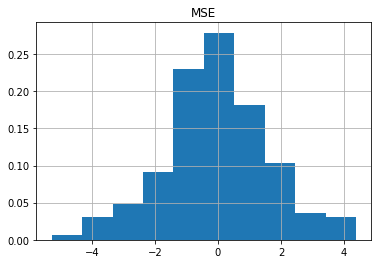

In [101]:
Test_data.hist("MSE",density=True)

##Training Set Calibration CIR Model

In [81]:
#using 480 bonds 80% of data
lists=X_1#['US808513BN40',	'US00254EMY58',	'US135087N757',	'US22550L2J94',	'US25155MKW00',	'US38141GZP26',	'US404280AU33',	'US606822BS23',	' US06051GFS30',	'US857477AW33',	'US00254EMZ24',	'US02209SAS23',	'US06739FHV67',	'US89114QCA40',	'US025816AZ26',	'US46625HRS12',	'US539439AS89',	'US298785HX70',	'US88579YAV39',	'US001055AM48',	'US1730T32J13',	'US931142CH46',	'US617482V925',	'US606822AN45',	'US251525AP63',	'US001055AM48',	'US1730T32J13']
def calib(params,lists,sig=0,r0=.043,N=100,T=12*30,dT=1/12,model='CIR',seed=500,rvs=None ):
  #generating interest rate sims
  if rvs is None:
    np.random.seed(seed)
    rvs = np.random.normal(0, 1, (N, T))
  r = np.zeros((N, T))
  r[:, 0] = r0
  a,b = params
  if model == 'CIR':
    for i in range(1, T):
      # counter = 0
      # print("checker", r[:, i-1])
      # print(r[:, i-1].shape)
      # if(np.isnan(r[:, i-1].any())):
      #   print("checker", r[:10, i-1])
      #   counter += 1
      # print(counter)
      r[:, i] = r[:, i-1] + a*(b-r[:, i-1])*dT + np.sqrt(r[:, i-1])*rvs[:, i]*math.sqrt(dT)*sig
      r[:, i][r[:, i] < 0] = 0
  if model == 'Vasicek':
    for i in range(1, T):
      r[:, i] = r[:, i-1] + a*(b-r[:, i-1])*dT + r[:, i-1]*rvs[:, i]*math.sqrt(dT)*sig
      r[:, i][r[:, i] < 0] = 0

  #creating discount rates from rates
  j=r.transpose()
  g=np.ones((j.shape))          

  for i in range(j.shape[1]):
    for k in range(j.shape[0]):
      j[k,i]=(1/(1+j[k,i]))**(1/12)

  for i in range(0,g.shape[1]):
    for k in range(0,g.shape[0]):
      if k==0:
        g[k][i]=j[k][i]
      else:
        g[k][i]=j[k][i]*g[k-1][i]

  df = pd.DataFrame (g)
  df2=pd.date_range(start='11/01/2022', periods= T, freq='M')
  listed=list(df2)
  for i in range(len(listed)):
    listed[i]=listed[i].replace(day=1)
  df['date']=listed
  df=df.set_index('date')

  #pricing function definition
  d={}
  value={}
  for name in lists:
   d[name] = pd.read_csv("/content/drive/Shareddrives/FIM 500 project group/Data/BBG Bond Data/"+name+".csv",nrows=2) # The dataframes are elements of the dictionary d
   d[name].set_index('Date',inplace=True)
   d[name]=d[name].transpose()
   d[name]=d[name].dropna(axis=1, how='all')
   d[name].index = pd.to_datetime(d[name].index)
   d[name].reset_index(inplace=True)
   d[name] = d[name].rename(columns = {'index':'date'})
   d[name]['modified_date'] = d[name]['date'] - pd.offsets.MonthBegin(1, normalize=True)
   d[name].set_index('modified_date', inplace=True)
   d[name]=d[name].join(df)
   d[name].reset_index(inplace=True)
   d[name] = d[name].rename(columns = {'index':'modified_date'})
   value[name]=pricing(d[name])
  avg_value={}
  for k, v in value.items():
    avg_value[k]=sum(v)/ int(len(v))
  #calculating MSE between current price and predicted Price
  price_pred=pd.DataFrame(avg_value.items() , columns=['ISIN', 'Price_Predicted'])
  price_curr=pd.read_excel("/content/drive/Shareddrives/FIM 500 project group/Data/Pure_Bonds.xlsx")
  MSE_df=pd.merge(price_pred,price_curr,on='ISIN')
  MSE_df=MSE_df.rename(columns={'Prices':'Price_Current'})
  MSE_df["Price_Current"]=pd.to_numeric(MSE_df["Price_Current"])
  MSE_df["Price_Predicted"]=pd.to_numeric(MSE_df['Price_Predicted'])
  MSE_df['MSE']=MSE_df['Price_Predicted']-MSE_df['Price_Current']
  SSS=np.square(MSE_df['MSE']).mean()
  #MSE_df['curr_price']=pd.merge(MSE_df,price_curr,how='left') 
  #Variance=(MSE_df['MSE']**2).mean()-(MSE_df['MSE'].mean())**2
  #minimising variance based on parameters
  return SSS, MSE_df

In [82]:
p=calib([0,0.02],lists)

In [83]:
p[0]

5.569748733153708

In [85]:
CIR_fixed=p[1]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3304909d0>]],
      dtype=object)

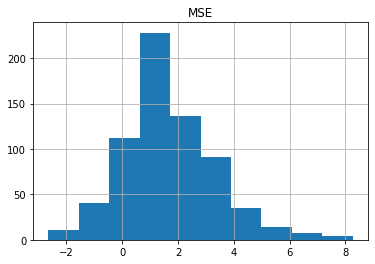

In [86]:
CIR_fixed.hist("MSE")

##Optimization for CIR Model

In [ ]:
bnd=[(0,1000),(0,0.2)]
params=[0.2,0.02]
s=minimize(calib,params,method='SLSQP',bounds=bnd,args=(lists,))
if s.success:
    fitted_params_SLSQP = s.x
    print(fitted_params_SLSQP)

[0.84907602 0.05682535]


## MSE with Calibrated Parameters

In [91]:
s=calib([0.849076,0.05682535],lists)

In [92]:
s[0]

2.856291316209354

In [ ]:
s[1]

,ISIN,Price_Predicted,Price_Current,MSE
0,US125523AX87,113.920251,110.163002,3.757249
1,US14020ACQ58,84.575430,80.572998,4.002432
2,US16877EAF25,86.570849,88.007004,-1.436155
3,US61760LAT26,98.608240,96.250000,2.358240
4,US02665WCE93,92.346675,93.222000,-0.875326
...,...,...,...,...
483,US191216DD90,80.031319,83.938004,-3.906684
484,US743315AJ20,108.028321,109.092003,-1.063682
485,US14913R2F38,96.315257,96.816002,-0.500745
486,US61746BDJ26,100.410430,99.900002,0.510428


In [ ]:
params = [0.849076,.05682535,.0221]
r0 = 0.043
d = MCMC(r0, params)

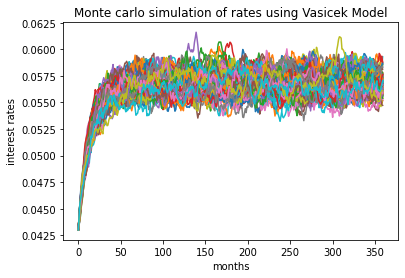

In [ ]:
plt.figure()
plt.xlabel("months")
plt.ylabel("interest rates")
plt.title("Monte carlo simulation of rates using Vasicek Model")
for i in range(100):
  plt.plot(d[i])
plt.show()

## Testing Calibrated Parameters: CIR Model

In [87]:
lists= X_2
def calib1(params,lists,sig=0.0221,r0=.043,N=100,T=12*30,dT=1/12,model='CIR',seed=500,rvs=None ):
  #generating interest rate sims
  if rvs is None:
    np.random.seed(seed)
    rvs = np.random.normal(0, 1, (N, T))
  r = np.zeros((N, T))
  r[:, 0] = r0
  a,b = params
  if model == 'CIR':
    for i in range(1, T):
      # counter = 0
      # print("checker", r[:, i-1])
      # print(r[:, i-1].shape)
      # if(np.isnan(r[:, i-1].any())):
      #   print("checker", r[:10, i-1])
      #   counter += 1
      # print(counter)
      r[:, i] = r[:, i-1] + a*(b-r[:, i-1])*dT + np.sqrt(r[:, i-1])*rvs[:, i]*math.sqrt(dT)*sig
      r[:, i][r[:, i] < 0] = 0
  if model == 'Vasicek':
    for i in range(1, T):
      r[:, i] = r[:, i-1] + a*(b-r[:, i-1])*dT + r[:, i-1]*rvs[:, i]*math.sqrt(dT)*sig
      r[:, i][r[:, i] < 0] = 0

  #creating discount rates from rates
  j=r.transpose()
  g=np.ones((j.shape))          

  for i in range(j.shape[1]):
    for k in range(j.shape[0]):
      j[k,i]=(1/(1+j[k,i]))**(1/12)

  for i in range(0,g.shape[1]):
    for k in range(0,g.shape[0]):
      if k==0:
        g[k][i]=j[k][i]
      else:
        g[k][i]=j[k][i]*g[k-1][i]

  df = pd.DataFrame (g)
  df2=pd.date_range(start='11/01/2022', periods= T, freq='M')
  listed=list(df2)
  for i in range(len(listed)):
    listed[i]=listed[i].replace(day=1)
  df['date']=listed
  df=df.set_index('date')

  #pricing function definition
  d={}
  value={}
  for name in lists:
   d[name] = pd.read_csv("/content/drive/Shareddrives/FIM 500 project group/Data/BBG Bond Data/"+name+".csv",nrows=2) # The dataframes are elements of the dictionary d
   d[name].set_index('Date',inplace=True)
   d[name]=d[name].transpose()
   d[name]=d[name].dropna(axis=1, how='all')
   d[name].index = pd.to_datetime(d[name].index)
   d[name].reset_index(inplace=True)
   d[name] = d[name].rename(columns = {'index':'date'})
   d[name]['modified_date'] = d[name]['date'] - pd.offsets.MonthBegin(1, normalize=True)
   d[name].set_index('modified_date', inplace=True)
   d[name]=d[name].join(df)
   d[name].reset_index(inplace=True)
   d[name] = d[name].rename(columns = {'index':'modified_date'})
   value[name]=pricing(d[name])
  avg_value={}
  for k, v in value.items():
    avg_value[k]=sum(v)/ int(len(v))
  #calculating MSE between current price and predicted Price
  price_pred=pd.DataFrame(avg_value.items() , columns=['ISIN', 'Price_Predicted'])
  price_curr=pd.read_excel("/content/drive/Shareddrives/FIM 500 project group/Data/Pure_Bonds.xlsx")
  MSE_df=pd.merge(price_pred,price_curr,on='ISIN')
  MSE_df=MSE_df.rename(columns={'Prices':'Price_Current'})
  MSE_df["Price_Current"]=pd.to_numeric(MSE_df["Price_Current"])
  MSE_df["Price_Predicted"]=pd.to_numeric(MSE_df["Price_Predicted"])
  MSE_df['MSE']=MSE_df['Price_Predicted']-MSE_df['Price_Current']
  SSS=np.square(MSE_df['MSE']).mean()
  #MSE_df['curr_price']=pd.merge(MSE_df,price_curr,how='left') 
  #Variance=(MSE_df['MSE']**2).mean()-(MSE_df['MSE'].mean())**2
  #minimising variance based on parameters
  return SSS,MSE_df

In [88]:
a=calib1([0.849076,.05682535],lists)

In [89]:
a[0]

2.8482332168829934

In [93]:
CIR_test=a[1]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3672708b0>]],
      dtype=object)

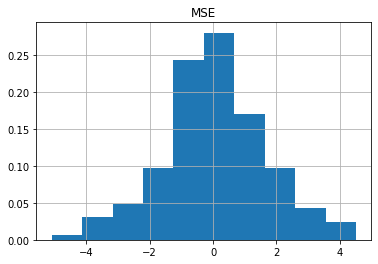

In [102]:
CIR_test.hist("MSE",density=True)